# Introduction

I was wondering if the long fragment lengths meant that kallisto had trouble with shorter genes.

# Setup

Get the notebook ready for the analysis

In [1]:
import numpy
import scanpy
import anndata
import os
import sys
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn
import logging


In [2]:
%matplotlib inline

In [3]:
LRSC = Path('~/proj/long-rna-seq-condor').expanduser()
if str(LRSC) not in sys.path:
    sys.path.append(str(LRSC))

from woldrnaseq.plot_genes_detected import (
    bin_library_quantification,
    plot_gene_detection_histogram,
)

In [4]:
scqc_root = Path('~/proj/single-cell-qc').expanduser()

(All the h5ad files used are at http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/c1_pseudo/ but I don't think the scanpy I'm using can directly stream off of https)

In [5]:
c1_pseudo = Path('c1_pseudo')

In [6]:
fragment_lengths = [50, 100, 200, 300, 400, 600, 800]

In [7]:
datasets = {
    'eff_length': {
        'rsem': scanpy.read_h5ad(c1_pseudo/'rsem_transcript_eff_length.h5ad').to_df().T,
        'bioanalyzer': scanpy.read_h5ad(c1_pseudo/'kallisto_transcript_eff_length.h5ad').to_df().T,
    },
    'length': {
        'rsem': scanpy.read_h5ad(c1_pseudo/'rsem_transcript_length.h5ad').to_df().T,
        'bioanalyzer': scanpy.read_h5ad(c1_pseudo/'kallisto_transcript_length.h5ad').to_df().T,
    },
    'est_counts': {
        'rsem': scanpy.read_h5ad(c1_pseudo/'rsem_transcript_counts.h5ad').to_df().T,
        'salmon': scanpy.read_h5ad(c1_pseudo/'salmon_minimal_transcript_counts.h5ad').to_df().T,
        'bioanalyzer': scanpy.read_h5ad(c1_pseudo/'kallisto_transcript_counts.h5ad').to_df().T,
    }
}

for column in ['length', 'eff_length', 'est_counts']:
    for length in fragment_lengths:
        print('Reading {} {}'.format(length, column))
        filename = c1_pseudo / 'kallisto_minimal_f{length}_transcript_{column}.h5ad'.format(length=length, column=column)
        table = scanpy.read_h5ad(filename).to_df().T
        #table = table.reindex(datasets['est_counts']['rsem'].index)
        datasets.setdefault(column, {})[length] = table

datasets['eff_length']['long'] = scanpy.read_h5ad(c1_pseudo/'kallisto_minimal_long_transcript_eff_length.h5ad').to_df().T
datasets['length']['long'] = scanpy.read_h5ad(c1_pseudo/'kallisto_minimal_long_transcript_length.h5ad').to_df().T
datasets['est_counts']['long'] = scanpy.read_h5ad(c1_pseudo/'kallisto_minimal_long_transcript_est_counts.h5ad').to_df().T


Reading 50 length
Reading 100 length
Reading 200 length
Reading 300 length
Reading 400 length
Reading 600 length
Reading 800 length
Reading 50 eff_length
Reading 100 eff_length
Reading 200 eff_length
Reading 300 eff_length
Reading 400 eff_length
Reading 600 eff_length
Reading 800 eff_length
Reading 50 est_counts
Reading 100 est_counts
Reading 200 est_counts
Reading 300 est_counts
Reading 400 est_counts
Reading 600 est_counts
Reading 800 est_counts


In [8]:
datasets.keys()

dict_keys(['eff_length', 'length', 'est_counts'])

In [9]:
datasets['est_counts'].keys()

dict_keys(['rsem', 'salmon', 'bioanalyzer', 50, 100, 200, 300, 400, 600, 800, 'long'])

In [10]:
#datasets['eff_length']['rsem'].shape, datasets['eff_length'][100].shape

In [11]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


In [12]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [13]:
eff_length_cors = compute_correlations(datasets['eff_length'])

In [14]:
est_count_cors = compute_correlations(datasets['est_counts'])

In [15]:
est_count_cors.keys()

dict_keys(['rsem', 'salmon', 'bioanalyzer', 50, 100, 200, 300, 400, 600, 800, 'long'])

In [16]:
def plot_cell_correlation_histogram(table, *, programs=None, bins=50):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(12,12))
    f.suptitle('Spearman')
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    return f

# Plot pairwise spearman correlation for different fragment-lengths

Bioanalyzer was computed from the mean cDNA value on the bioanalyzer and varied from around 1000 to 1850 bp. rsem is the results from running star/rsem on each cell.

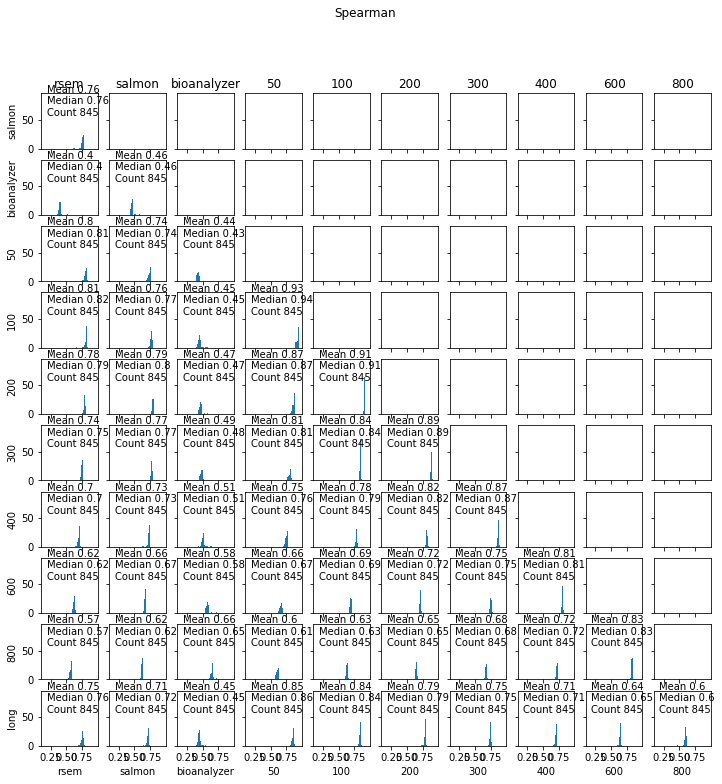

In [17]:
plot_cell_correlation_histogram(est_count_cors)

In [18]:
def plot_minimum_length(table, length, top=200):
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)
    table['eff_length'][length][table['est_counts'][length] > 0].min().plot.density(ax=ax)
    ax.set_xlabel('minimum transcript length')
    ax.set_ylabel('density')
    ax.set_title('length = {}'.format(length))
    ax.set_xlim(0, top)
    return f

# Kernal density estimates for the shortest detected transcripts by read length

this shows the detected minimum transcript lengths over all the 845 cells

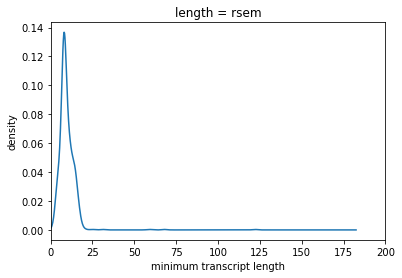

In [19]:
plot_minimum_length(datasets, 'rsem')

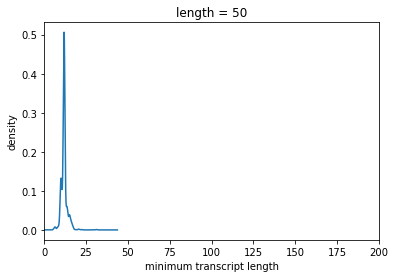

In [20]:
plot_minimum_length(datasets, 50)

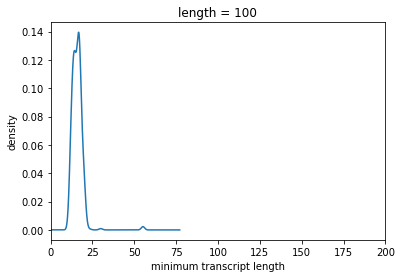

In [21]:
plot_minimum_length(datasets, 100)

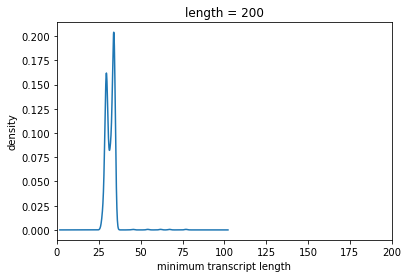

In [22]:
plot_minimum_length(datasets, 200)

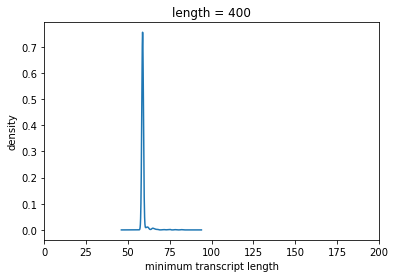

In [23]:
plot_minimum_length(datasets, 400)

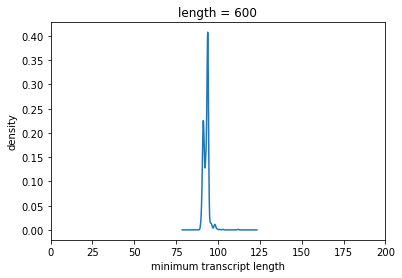

In [24]:
plot_minimum_length(datasets, 600)

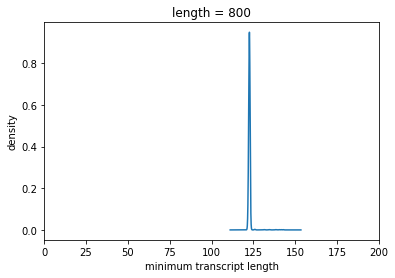

In [25]:
plot_minimum_length(datasets, 800)

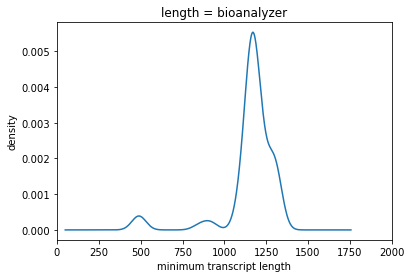

In [26]:
plot_minimum_length(datasets, 'bioanalyzer', 2000)

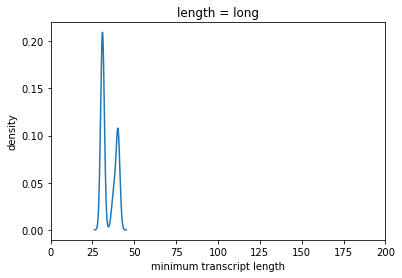

In [27]:
plot_minimum_length(datasets, 'long')

# Look at transcript lengths

In [28]:
def plot_length(table, length):
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)
    table['eff_length'][length][table['est_counts'][length] > 0].count().plot.density(ax=ax)
    ax.set_xlabel('transcript length')
    ax.set_ylabel('density')
    ax.set_title('length = {}'.format(length))
    #ax.set_xlim(0, 200)
    return f

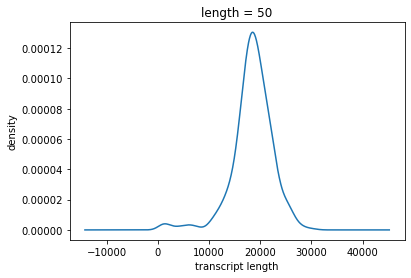

In [29]:
plot_length(datasets, 50)

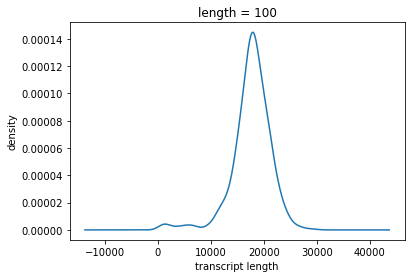

In [30]:
plot_length(datasets, 100)

In [31]:
datasets['eff_length'][200][datasets['est_counts'][200] > 0].count(axis=1)

transcript_id
10000                    0
10001                    0
10002                    0
10003                    0
10004                    0
                      ... 
tSpikein_ERCC-00165    819
tSpikein_ERCC-00168     39
tSpikein_ERCC-00170    695
tSpikein_ERCC-00171    845
tSpikein_phiX174        37
Length: 168207, dtype: int64

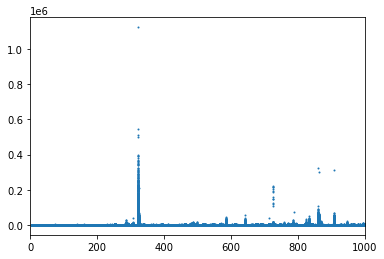

In [32]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.scatter(datasets['eff_length'][200], datasets['est_counts'][200], s=1)
ax.set_xlim(0, 1000)
f

In [33]:
#datasets['eff_length'][200], datasets['eff_length'][200].mean(axis=1)

Is the "eff_length" the same for all the cells? Easiest way to check was to see if every cells effected length equaled the mean. (Or should I have made this simpler and just asked if they were the same as the first one?

In [34]:
m = datasets['eff_length'][200].mean(axis=1)

In [35]:
m

transcript_id
10000                    11.296789
10001                    11.363843
10002                    11.363843
10003                    11.499902
10004                    11.708388
                          ...     
tSpikein_ERCC-00165     673.000000
tSpikein_ERCC-00168     825.000000
tSpikein_ERCC-00170     824.000000
tSpikein_ERCC-00171     306.000000
tSpikein_phiX174       5187.000000
Length: 168207, dtype: float32

In [36]:
datasets['eff_length'][200]['18087_F1'][datasets['eff_length'][200]['18087_F1'] != m]

transcript_id
10000                  11.296700
10001                  11.363800
10002                  11.363800
10003                  11.499800
10004                  11.708400
                         ...    
tSpikein_ERCC-00023    77.050400
tSpikein_ERCC-00051    77.907097
tSpikein_ERCC-00054    77.907097
tSpikein_ERCC-00077    77.050400
tSpikein_ERCC-00134    77.907097
Name: 18087_F1, Length: 43767, dtype: float32

In [37]:
close_enough = []
for column in datasets['eff_length'][200]:
    close_enough.append(numpy.allclose(datasets['eff_length'][200][column], m))

Yes they're all close enough (within $10^{-5}$)

In [38]:
numpy.all(close_enough)

False

# Plot detected counts for different transcript lengths

this plot series is against just one cell since it's a bit much cycling over all the different read lengths

In [39]:
def plot_detection(datasets, quantification, cell_id, length, mean_eff_length):
    d = datasets[quantification][length].copy()
    d['eff_length'] = mean_eff_length
    libraries = {
        '0-100': d[cell_id][d['eff_length'] < 100],
        '100-200': d[cell_id][(d['eff_length'] >= 100) & (d['eff_length'] < 200)],
        '200-300': d[cell_id][(d['eff_length'] >= 200) & (d['eff_length'] < 300)],
        '300-400': d[cell_id][(d['eff_length'] >= 300) & (d['eff_length'] < 400)],
        '400-500': d[cell_id][(d['eff_length'] >= 400) & (d['eff_length'] < 500)],
        '500-600': d[cell_id][(d['eff_length'] >= 500) & (d['eff_length'] < 600)],
        '600-700': d[cell_id][(d['eff_length'] >= 600) & (d['eff_length'] < 700)],
        '700-800': d[cell_id][(d['eff_length'] >= 700) & (d['eff_length'] < 800)],
        '800-900': d[cell_id][(d['eff_length'] >= 800) & (d['eff_length'] < 900)],
        '900-1000': d[cell_id][(d['eff_length'] >= 900) & (d['eff_length'] < 1000)],
        '1000+': d[cell_id][(d['eff_length'] >= 1000)],
    }

    libraries = pandas.DataFrame(libraries)
    bins = bin_library_quantification(libraries, 'est_counts')
    f = plot_gene_detection_histogram(bins, '{cell_id}@{length}'.format(cell_id=cell_id, length=length))
    return f

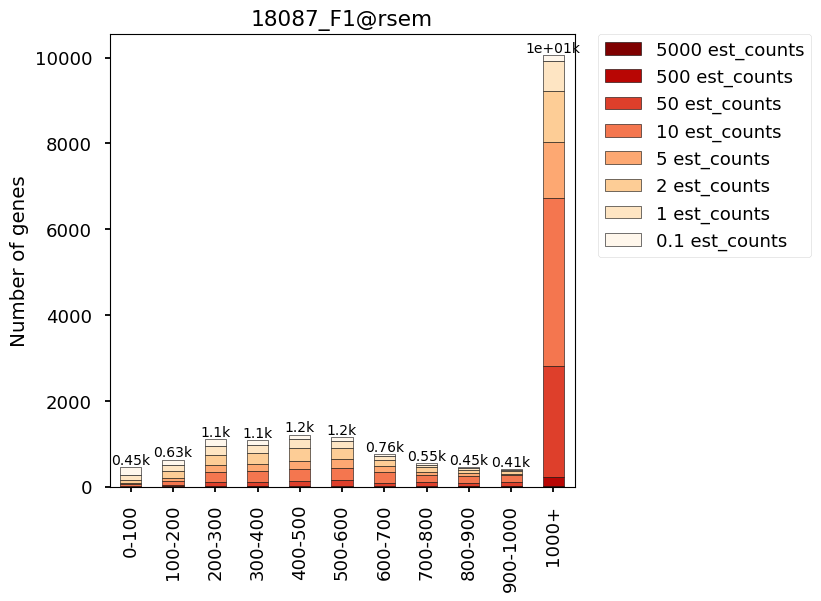

In [40]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 'rsem', m)
f

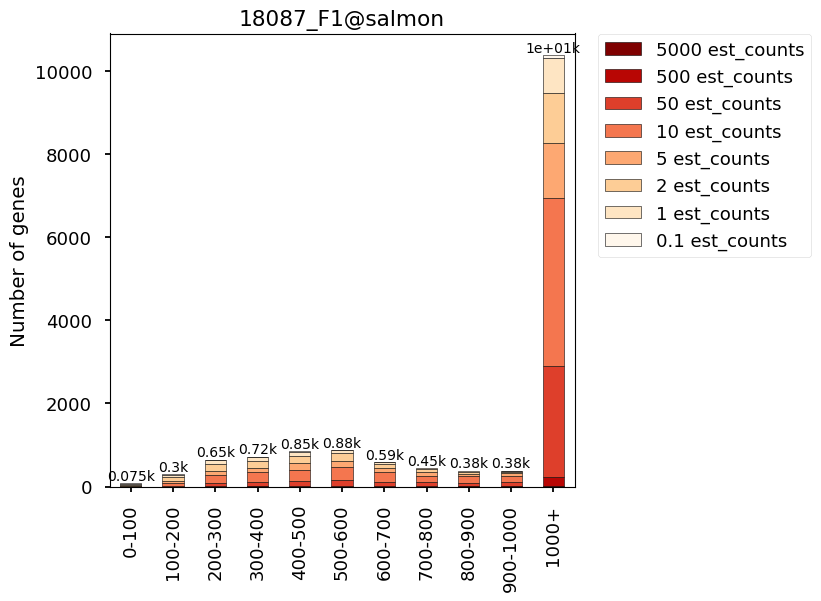

In [41]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 'salmon', m)
f

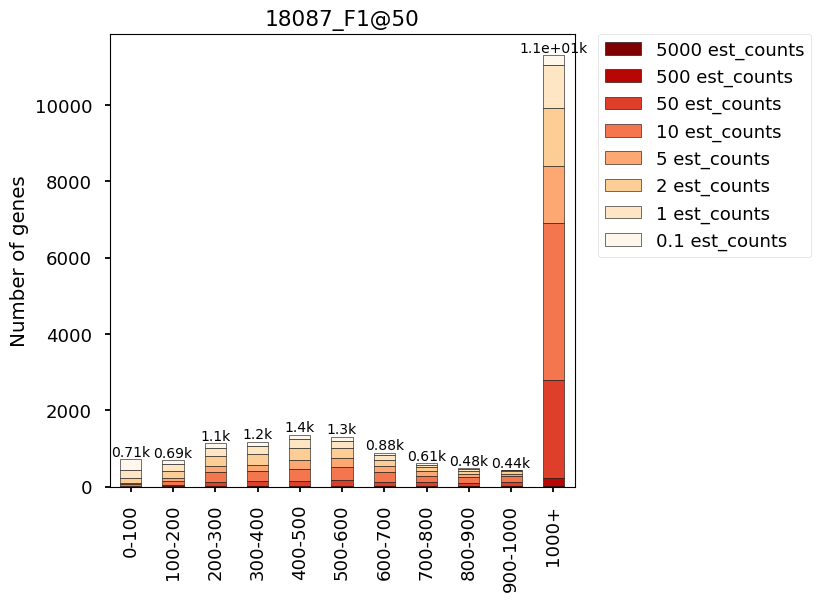

In [42]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 50, m)
f

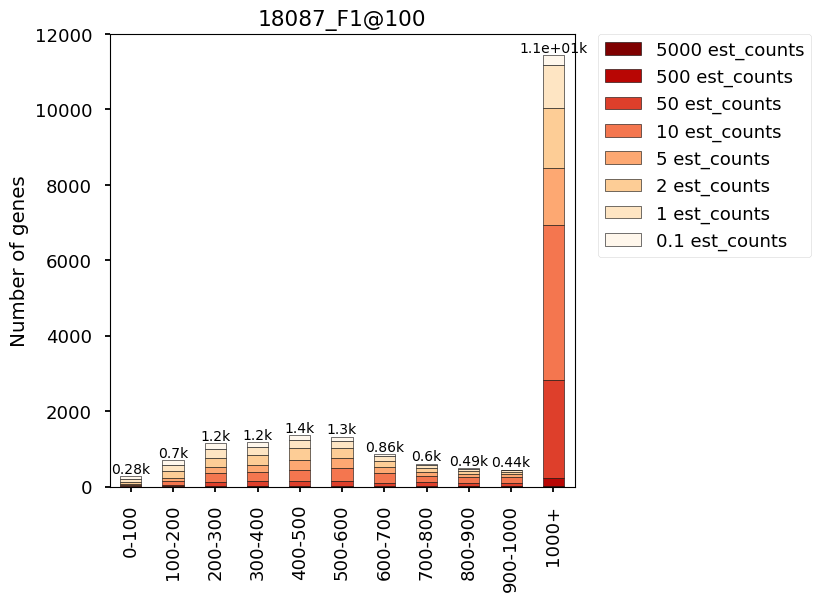

In [43]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 100, m)
f

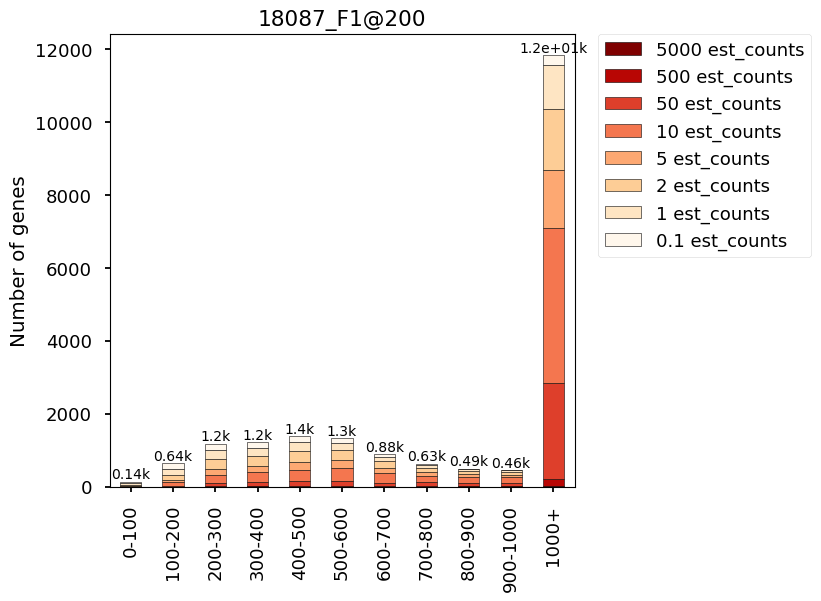

In [44]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 200, m)
f

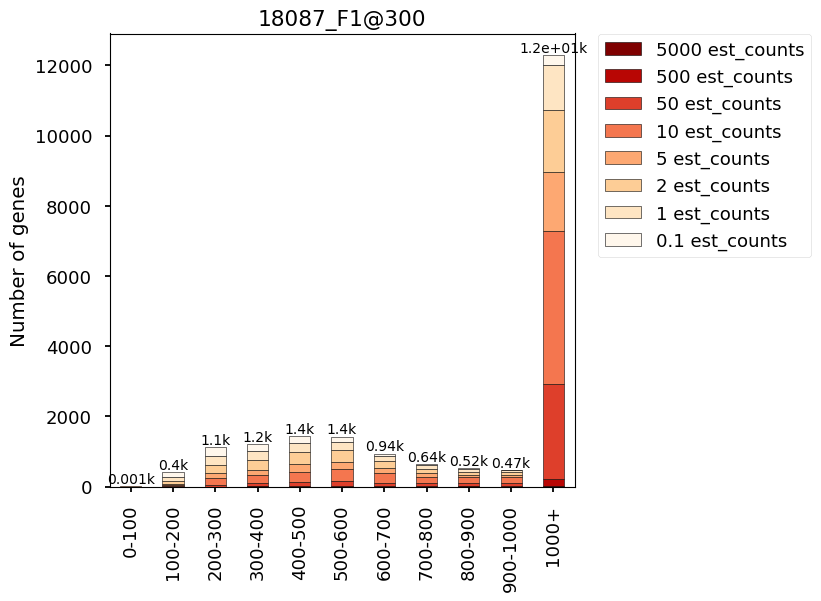

In [45]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 300, m)
f

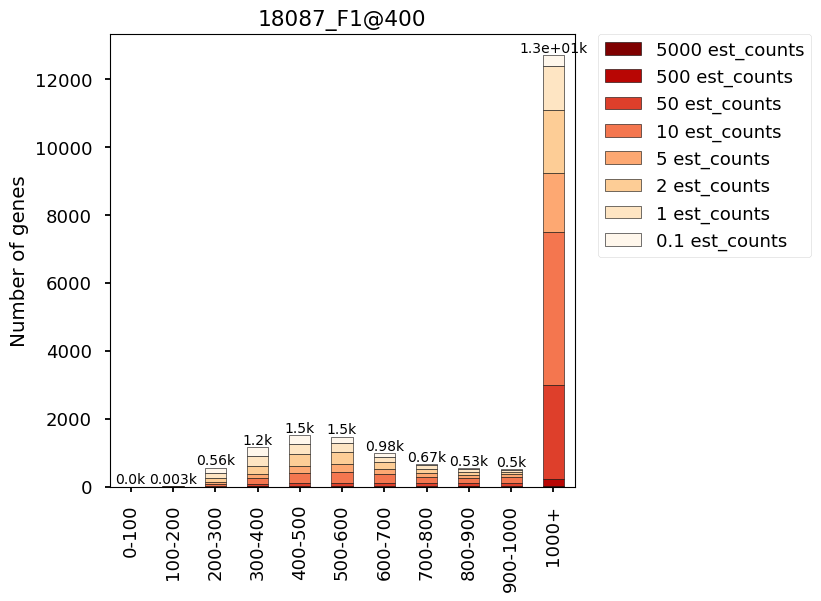

In [46]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 400, m)
f

/woldlab/loxcyc/home/diane/proj/long-rna-seq-condor/woldrnaseq/plot_genes_detected.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure(figsize=figsize, dpi=dpi)


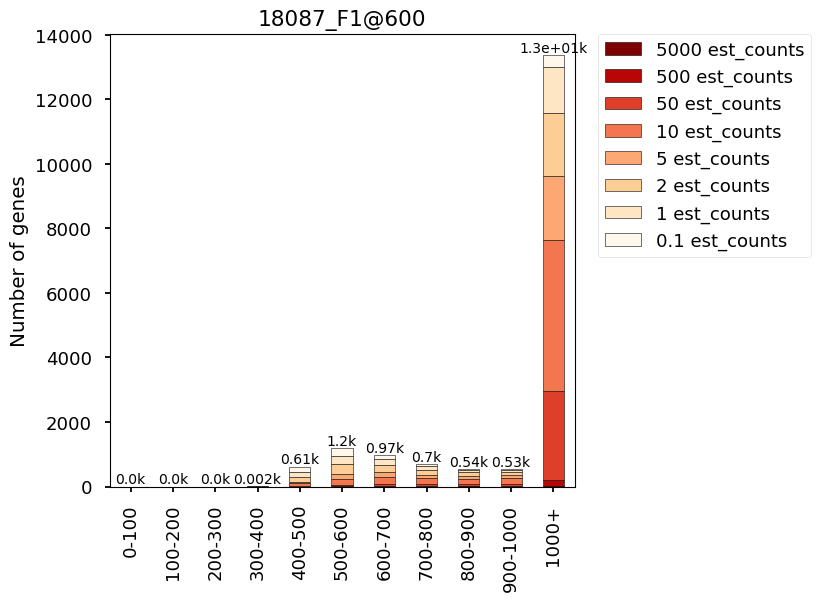

In [47]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 600, m)
f

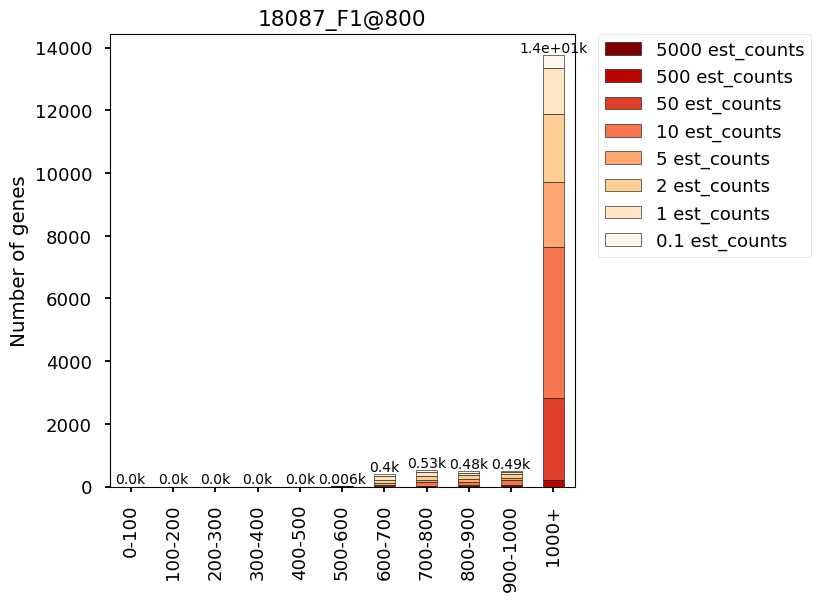

In [48]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 800, m)
f

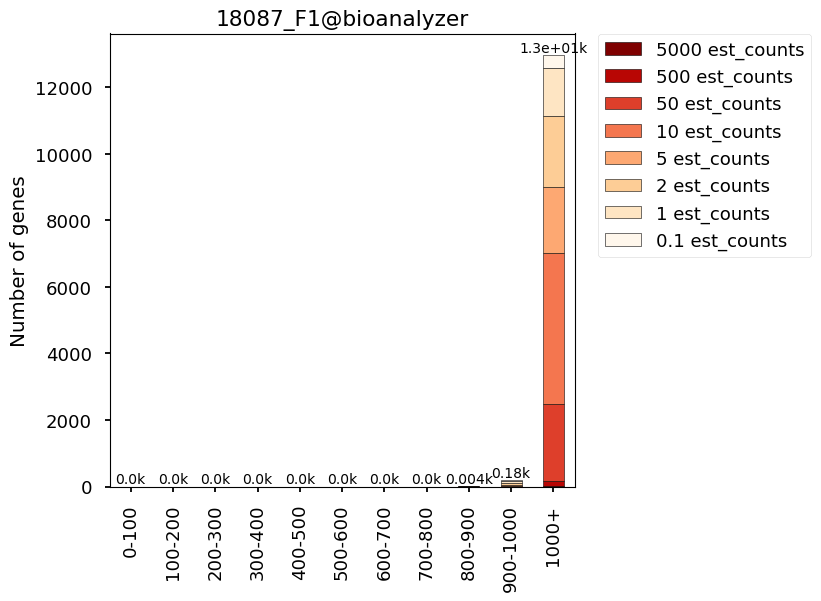

In [49]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 'bioanalyzer', m)
f

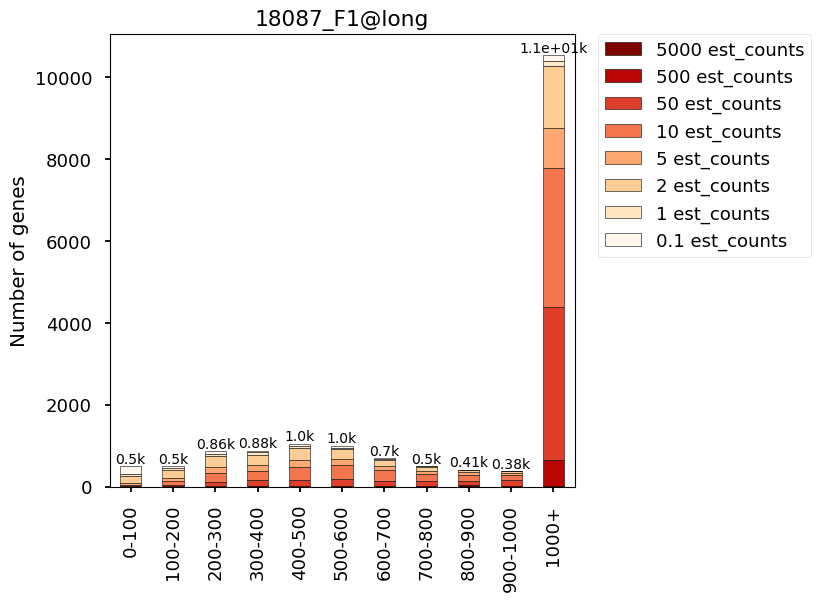

In [50]:
f = plot_detection(datasets, 'est_counts', '18087_F1', 'long', m)
f

# Plot detection by length for the sum of genes for all 845 cells.

In [51]:
def plot_aggregate_detection(table, quantification, cell_id, length, mean_eff_length):
    d = table.copy()
    d['eff_length'] = mean_eff_length
    libraries = {
        '0-100': d[cell_id][d['eff_length'] < 100],
        '100-200': d[cell_id][(d['eff_length'] >= 100) & (d['eff_length'] < 200)],
        '200-300': d[cell_id][(d['eff_length'] >= 200) & (d['eff_length'] < 300)],
        '300-400': d[cell_id][(d['eff_length'] >= 300) & (d['eff_length'] < 400)],
        '400-500': d[cell_id][(d['eff_length'] >= 400) & (d['eff_length'] < 500)],
        '500-600': d[cell_id][(d['eff_length'] >= 500) & (d['eff_length'] < 600)],
        '600-700': d[cell_id][(d['eff_length'] >= 600) & (d['eff_length'] < 700)],
        '700-800': d[cell_id][(d['eff_length'] >= 700) & (d['eff_length'] < 800)],
        '800-900': d[cell_id][(d['eff_length'] >= 800) & (d['eff_length'] < 900)],
        '900-1000': d[cell_id][(d['eff_length'] >= 900) & (d['eff_length'] < 1000)],
        '1000+': d[cell_id][(d['eff_length'] >= 1000)],
    }

    libraries = pandas.DataFrame(libraries)
    bins = bin_library_quantification(libraries, quantification)
    f = plot_gene_detection_histogram(bins, '{cell_id}@{length}'.format(cell_id=cell_id, length=length))
    return f

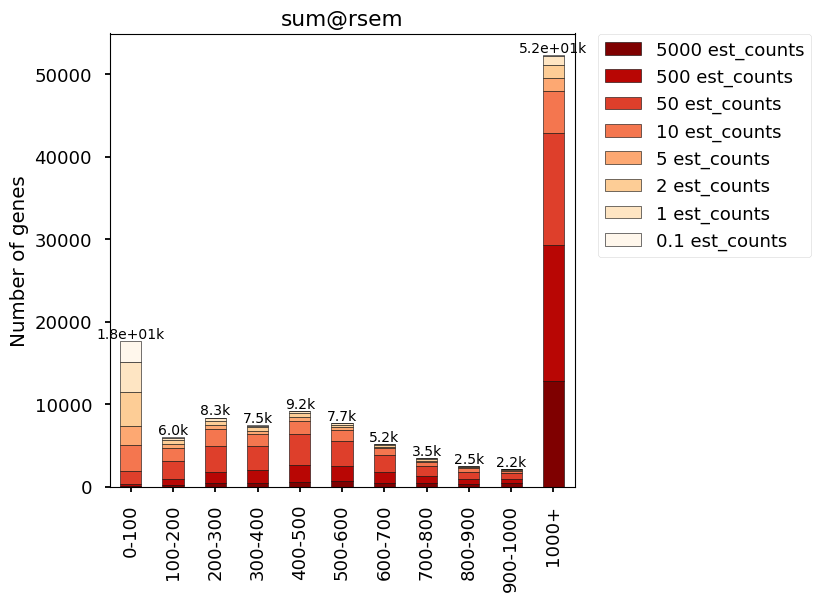

In [52]:
plot_aggregate_detection(datasets['est_counts']['rsem'].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 'rsem', m)

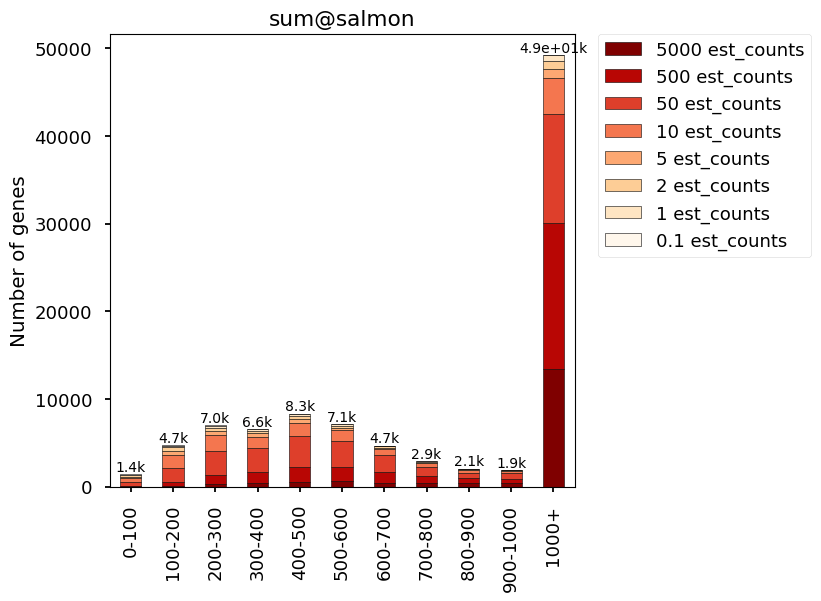

In [53]:
plot_aggregate_detection(datasets['est_counts']['salmon'].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 'salmon', m)

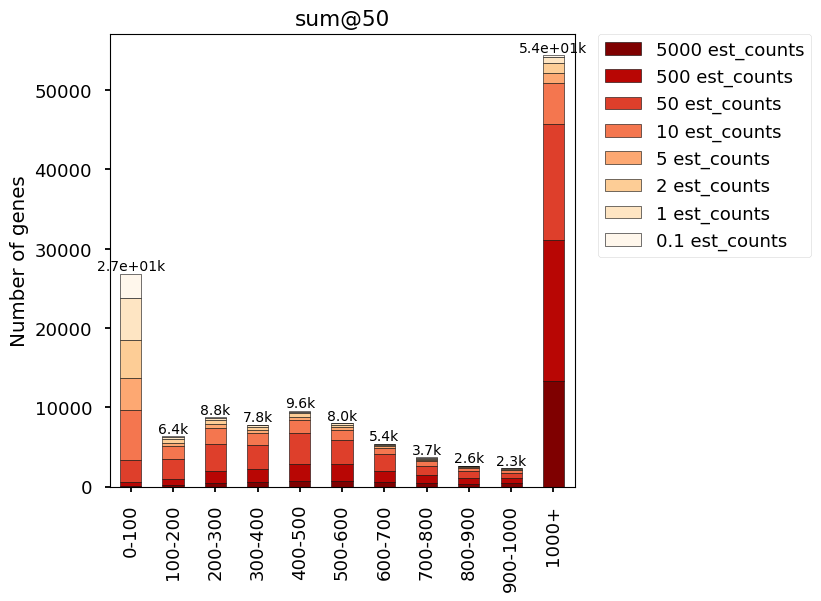

In [54]:
plot_aggregate_detection(datasets['est_counts'][50].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 50, m)

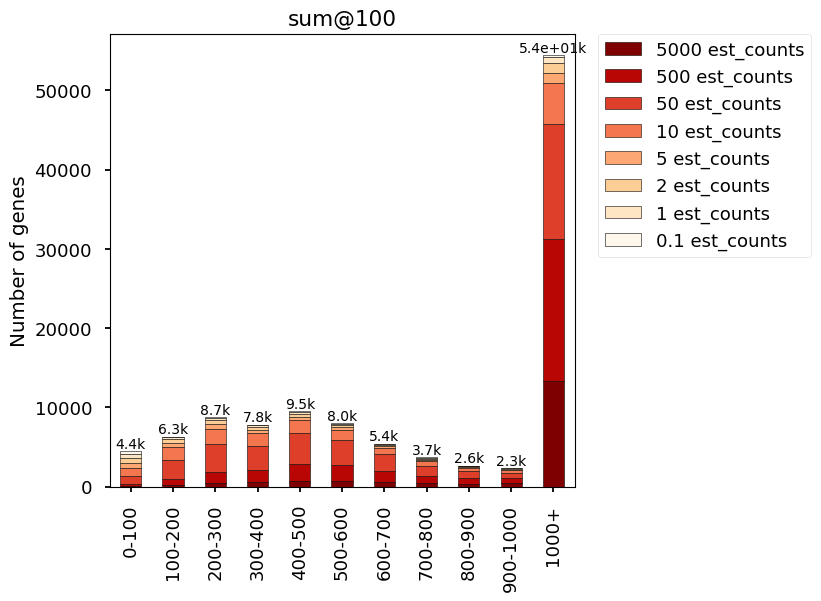

In [55]:
plot_aggregate_detection(datasets['est_counts'][100].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 100, m)

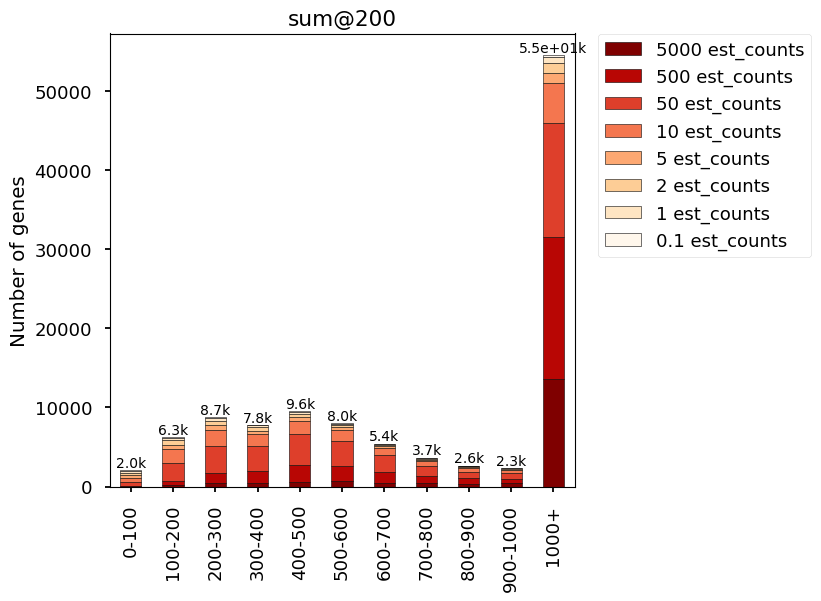

In [56]:
plot_aggregate_detection(datasets['est_counts'][200].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 200, m)

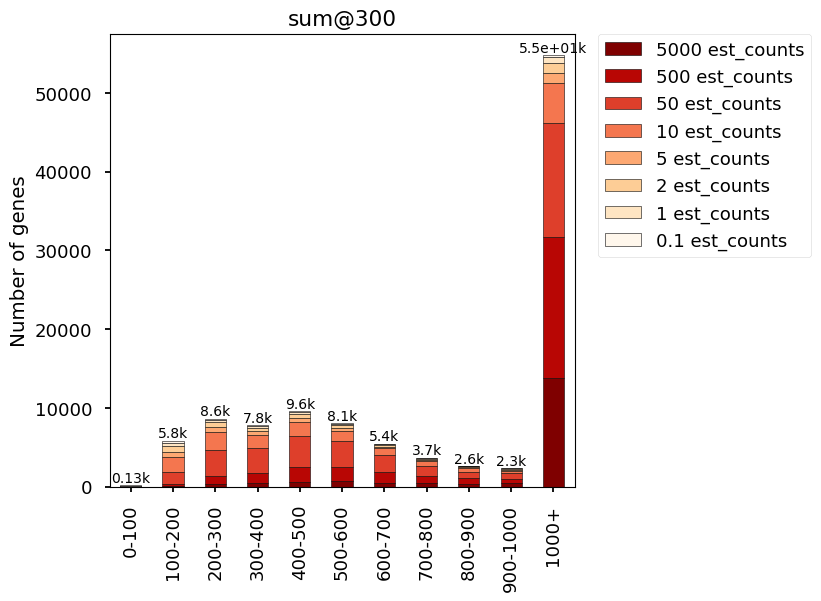

In [57]:
plot_aggregate_detection(datasets['est_counts'][300].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 300, m)

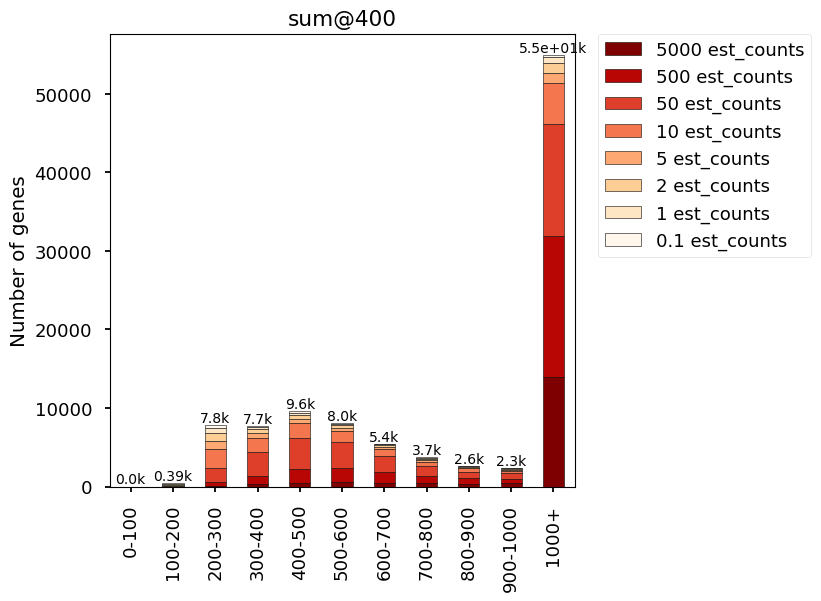

In [58]:
plot_aggregate_detection(datasets['est_counts'][400].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 400, m)

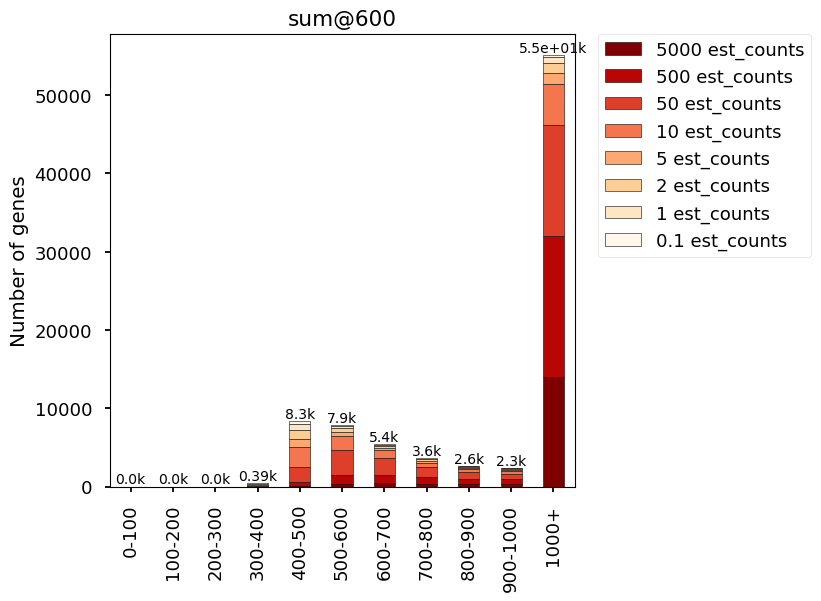

In [59]:
plot_aggregate_detection(datasets['est_counts'][600].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 600, m)

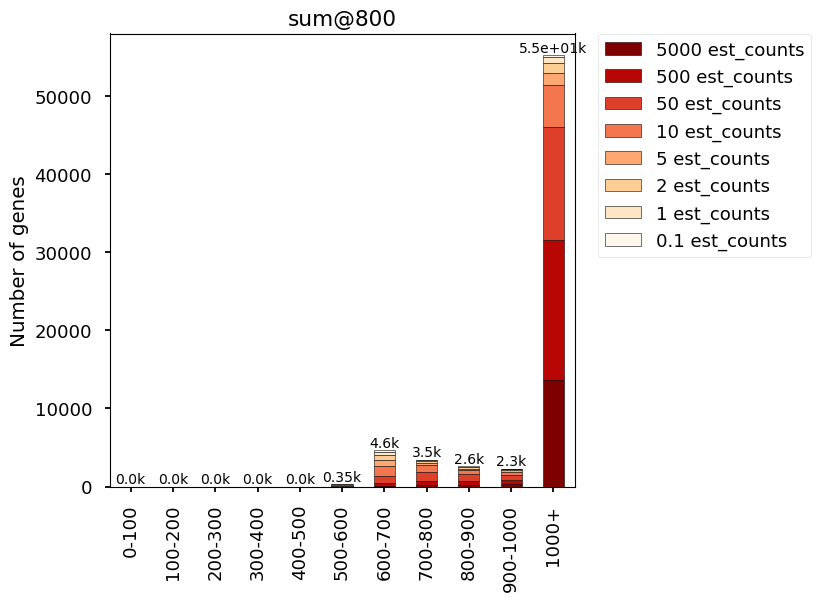

In [60]:
plot_aggregate_detection(datasets['est_counts'][800].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 800, m)

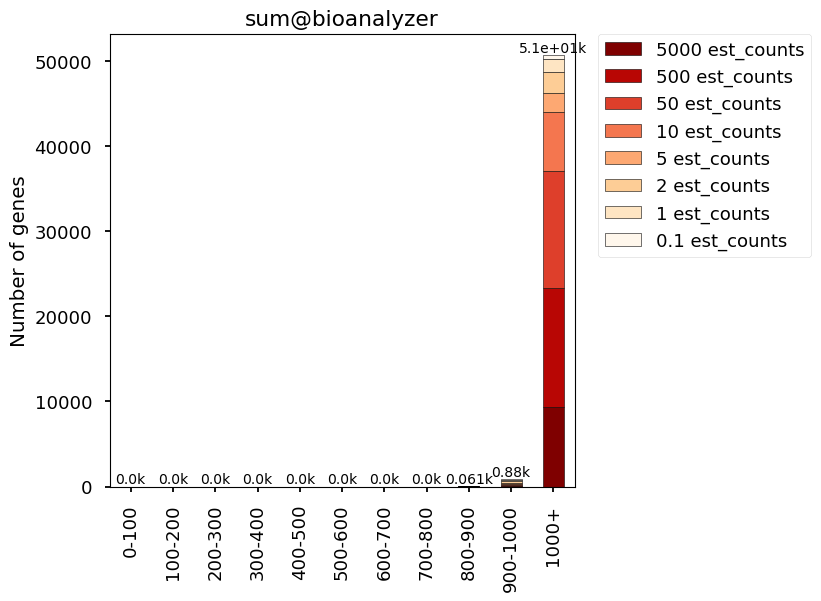

In [61]:
plot_aggregate_detection(datasets['est_counts']['bioanalyzer'].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 'bioanalyzer', m)

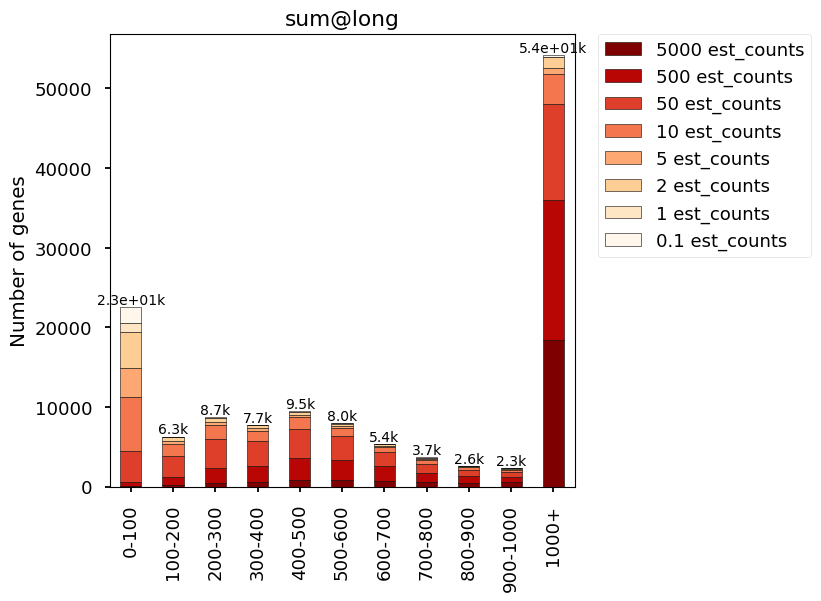

In [62]:
plot_aggregate_detection(datasets['est_counts']['long'].sum(axis=1).to_frame('sum'), 'est_counts', 'sum', 'long', m)

# Scatter plots between two runs

In [63]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(table[name_x][cell_id]+0.01, table[name_y][cell_id]+0.01, color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    spike_spearman = scipy.stats.spearmanr(table[name_x][cell_id][-97:], table[name_y][cell_id][-97:])[0]
    count = numpy.sum((table[name_x][cell_id] > 0) & (table[name_y][cell_id] > 0))
    ax.set_title(f'id {cell_id}\n{spearman:0.4}\nCount: {count}\nSpike spear: {spike_spearman}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    return f


# Scatter plots of kallisto vs rsem for different fragment lengths for 18087_F1

(It's the same cell as I used for the first genes detected plots)

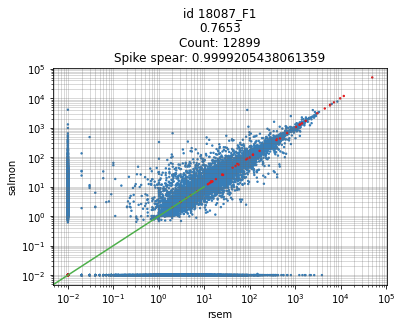

In [64]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 'salmon', '18087_F1')

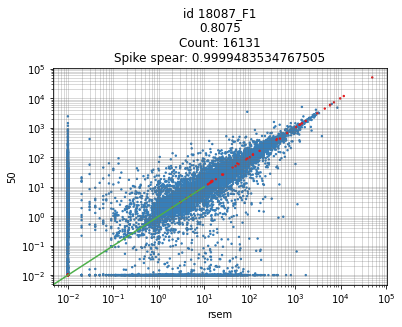

In [65]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 50, '18087_F1')

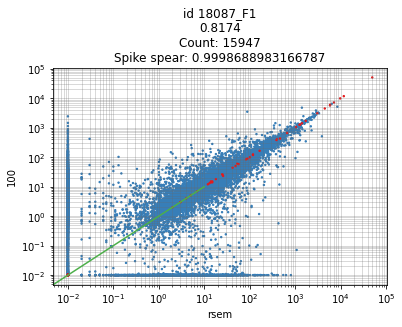

In [66]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 100, '18087_F1')

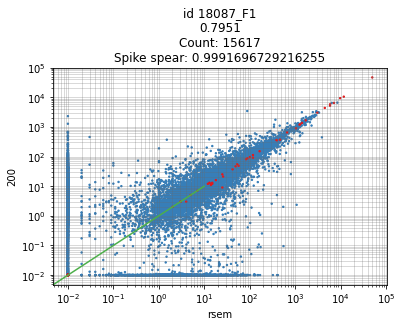

In [67]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 200, '18087_F1')

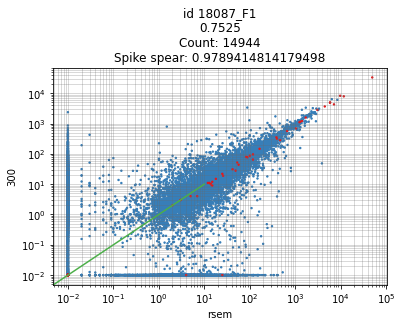

In [68]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 300, '18087_F1')

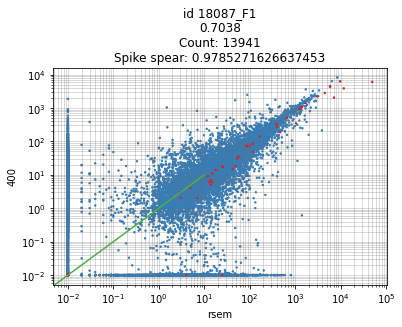

In [69]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 400, '18087_F1')

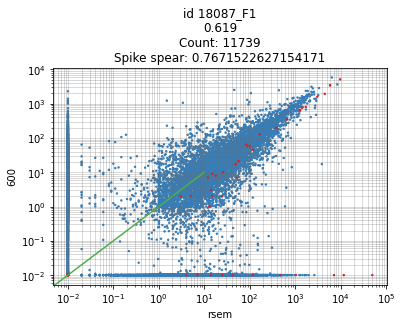

In [70]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 600, '18087_F1')

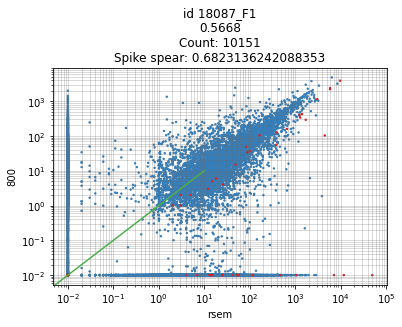

In [71]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 800, '18087_F1')

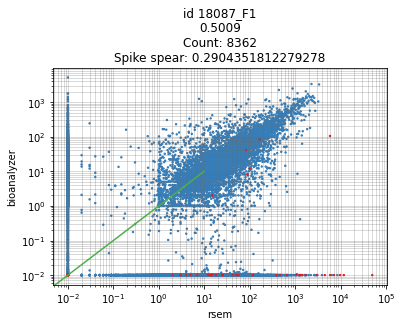

In [72]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 'bioanalyzer', '18087_F1')

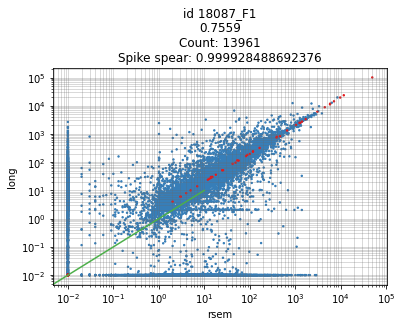

In [73]:
sc_scatter(datasets['est_counts'], est_count_cors, 'rsem', 'long', '18087_F1')

In [74]:
def load_spikes(ID, matrix_spikes):
    spikes_path = Path(f'~/proj/single-cell-qc/singleqc/{ID}.tsv').expanduser()
    spikes = pandas.read_csv(spikes_path, sep='\t', index_col='gene_id')
    #print(spikes)
    
    spikes.index = [x.replace('gSpikein_', 'tSpikein_') for x in spikes.index]
    
    concentration = {}
    missing = []
    for name in matrix_spikes:
        _, short = name.split('_')
        if name in spikes.index:
            concentration[name] = spikes.loc[name]
        elif short in spikes.index:
            concentration[name] = spikes.loc[short]
        else:
            concentration[name] = 0
            missing.append(name)
    print('These spike IDs were not in concentration table: {}'.format(','.join(missing)))
    return pandas.DataFrame(concentration).T, missing

def plot_polyfit(ax, x, y, bottom=0):
    p, residuals, rank, singular_values, rcond = numpy.polyfit(x, y, 1, full=True)
    m, b = p
    #print(p, residuals, rank, singular_values, rcond)
    def line(x):
        return m * x + b
    def yline(y):
        return (y-b)/m
    args = [bottom, yline(y.max())], [line(bottom), y.max()]
    #print(args)
    ax.plot(*args)
    ax.set_title('RSS = {:.5}'.format(residuals[0]))
    
def plot_spikein_counts(columns, labels, spikes, bottom=0):
    size = 6
    f = pyplot.figure(figsize=(16,4))
    #f.suptitle('log$_2$ Transcript Counts')
    axes = f.subplots(1, len(columns), sharex=True, sharey=True)
    #cmap = cm.get_cmap('plasma')
    for i, c in enumerate(columns):
        x = c.loc[spikes.index]
        scatter = axes[i].scatter(x, spikes['concentration'], c=spikes['length'], cmap='plasma', s=size)
        axes[i].set_xlabel(labels[i])
        axes[i].set_ylabel('spike concentrations')
        plot_polyfit(axes[i], x, spikes['concentration'], bottom=bottom)
    cb = f.colorbar(scatter, ax=axes)
    cb.set_label('length')
    return f

In [75]:
gspike = [x for x in datasets['est_counts']['rsem'].index if x.startswith('tSpike')]
len(gspike)

97

In [76]:
encsr535lmc, lmc_missing = load_spikes('ENCSR535LMC', gspike)

These spike IDs were not in concentration table: tSpikein_ERCC-00007,tSpikein_ERCC-00018,tSpikein_ERCC-00023,tSpikein_ERCC-00128,tSpikein_phiX174


RSS is the Residuals a sum of squared residuals of the least-squares fit, the effective rank of the scaled Vandermonde coefficient matrix, its singular values, and the specified value of rcond.

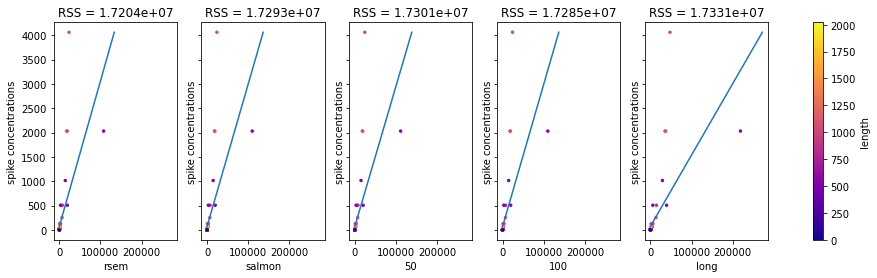

In [77]:
runs = ['rsem', 'salmon', 50, 100, 'long']
plot_spikein_counts(
    [datasets['est_counts'][x].mean(axis=1) for x in runs],
    runs,
    encsr535lmc)

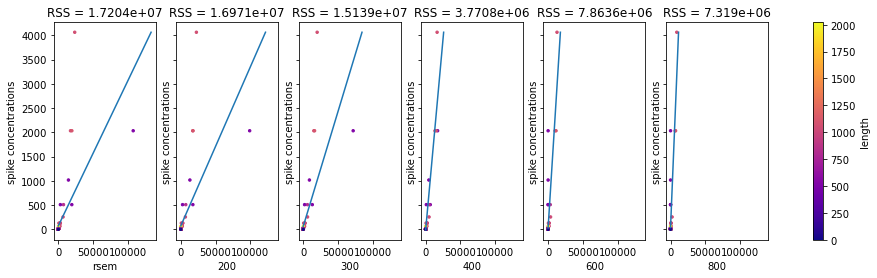

In [78]:
runs = ['rsem', 200, 300, 400, 600, 800]
plot_spikein_counts(
    [datasets['est_counts'][x].mean(axis=1) for x in runs],
    runs,
    encsr535lmc)

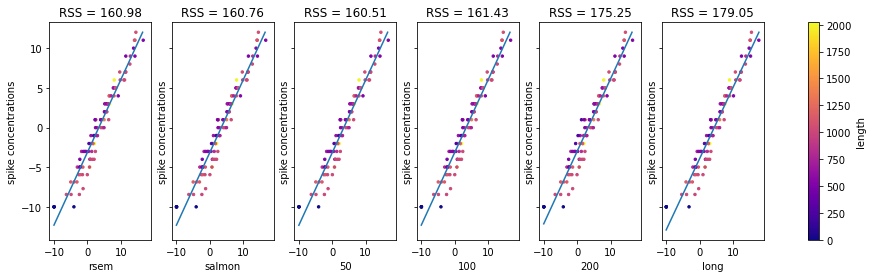

In [79]:
runs = ['rsem', 'salmon', 50, 100, 200, 'long']
encsr535lmc_l2 = encsr535lmc.copy()
encsr535lmc_l2['concentration'] = numpy.log2(encsr535lmc['concentration']+.001)
plot_spikein_counts(
    [numpy.log2(datasets['est_counts'][x].mean(axis=1)+.001) for x in runs],
    runs,
    encsr535lmc_l2, bottom=-10)

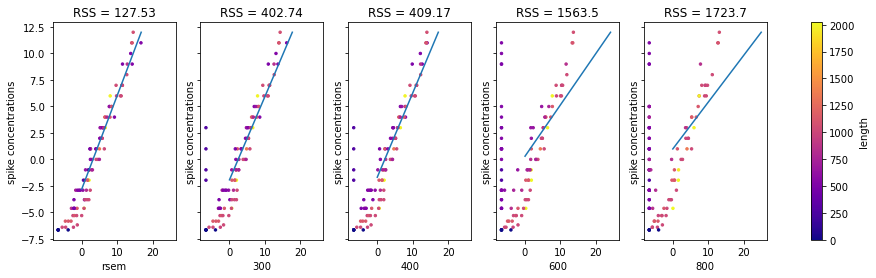

In [80]:
runs = ['rsem', 300, 400, 600, 800]
encsr535lmc_l2 = encsr535lmc.copy()
encsr535lmc_l2['concentration'] = numpy.log2(encsr535lmc['concentration']+.01)
plot_spikein_counts(
    [numpy.log2(datasets['est_counts'][x].mean(axis=1)+.01) for x in runs],
    runs,
    encsr535lmc_l2)